<a href="https://colab.research.google.com/github/mohankrishna12/BasicML/blob/main/transfer_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Credits: https://pytorch.org/
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

Load Data
=========
A model to classify **ants** and **bees**. We have about 120 training images each for ants and bees.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/RIC_CV

/content/drive/MyDrive/RIC_CV


In [ ]:
#!unzip /content/drive/MyDrive/RIC_CV/hymenoptera_data.zip

Archive:  /content/drive/MyDrive/RIC_CV/hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hyme

In [9]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/RIC_CV/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


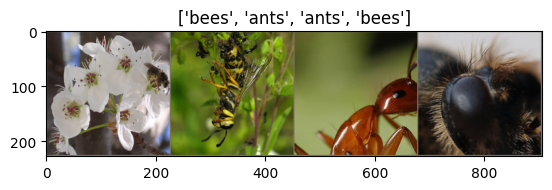

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))


out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================


In [43]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()


    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)


            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0


                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)


                    optimizer.zero_grad()


                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)


                        if phase == 'train':
                            loss.backward()
                            optimizer.step()


                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')


        model.load_state_dict(torch.load(best_model_params_path))
    return model

Visualizing the model predictions
=================================


In [44]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [45]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False


num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [46]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.5680 Acc: 0.6844
val Loss: 0.2593 Acc: 0.9477

Epoch 1/29
----------
train Loss: 0.5010 Acc: 0.7746
val Loss: 0.2104 Acc: 0.9608

Epoch 2/29
----------
train Loss: 0.4405 Acc: 0.7951
val Loss: 0.2058 Acc: 0.9346

Epoch 3/29
----------
train Loss: 0.3577 Acc: 0.8402
val Loss: 0.1929 Acc: 0.9412

Epoch 4/29
----------
train Loss: 0.6932 Acc: 0.7336
val Loss: 0.2676 Acc: 0.9085

Epoch 5/29
----------
train Loss: 0.5572 Acc: 0.7623
val Loss: 0.1860 Acc: 0.9608

Epoch 6/29
----------
train Loss: 0.5509 Acc: 0.7746
val Loss: 0.2652 Acc: 0.9085

Epoch 7/29
----------
train Loss: 0.3615 Acc: 0.8443
val Loss: 0.1748 Acc: 0.9477

Epoch 8/29
----------
train Loss: 0.3169 Acc: 0.8607
val Loss: 0.1911 Acc: 0.9412

Epoch 9/29
----------
train Loss: 0.3074 Acc: 0.8689
val Loss: 0.1942 Acc: 0.9477

Epoch 10/29
----------
train Loss: 0.3390 Acc: 0.8525
val Loss: 0.1722 Acc: 0.9542

Epoch 11/29
----------
train Loss: 0.3274 Acc: 0.8607
val Loss: 0.1771 Acc: 0.9412

Ep

In [47]:
torch.save(model_conv.state_dict(), '/content/drive/MyDrive/RIC_CV/model_ConvNet_ft.pth')

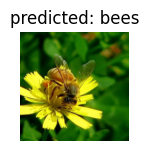

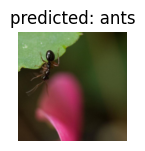

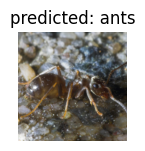

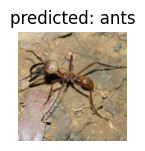

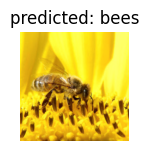

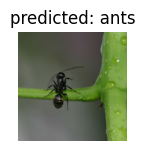

In [48]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [49]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

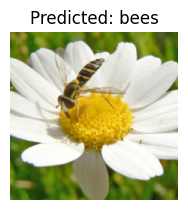

In [50]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/RIC_CV/hymenoptera_data/val/bees/144098310_a4176fd54d.jpg'
)
plt.ioff()
plt.show()

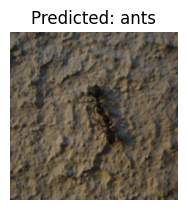

In [51]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/RIC_CV/hymenoptera_data/val/ants/157401988_d0564a9d02.jpg'
)
plt.ioff()
plt.show()


In [52]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        self.model.zero_grad()
        output[0, class_idx].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.cpu().numpy()

In [53]:
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

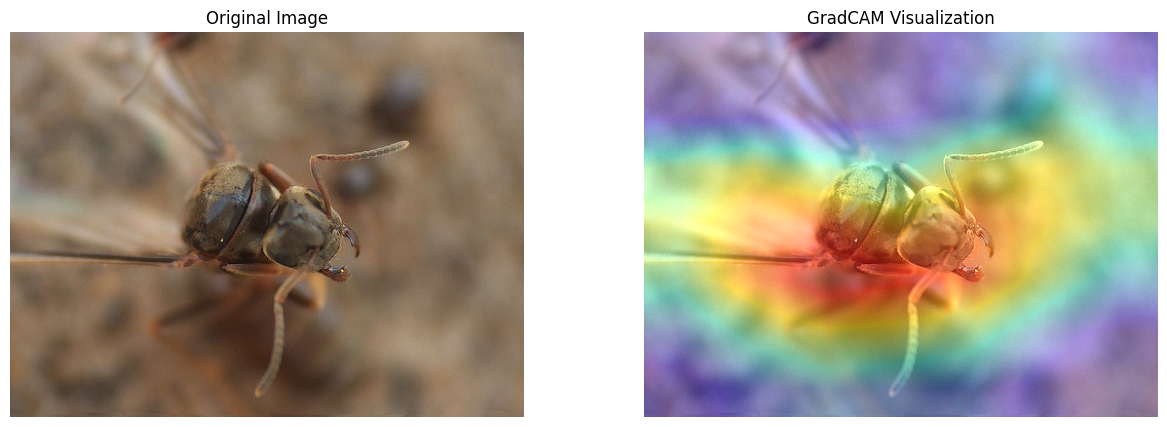

Predicted class index: 0


In [57]:
import torch.nn.functional as F
import cv2
class ResNet(models.ResNet):
    def __init__(self, num_classes=2):
        super(ResNet, self).__init__(models.resnet.BasicBlock, [2, 2, 2, 2])
        self.fc = nn.Linear(512, num_classes)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        self.model.zero_grad()
        output[0, class_idx].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.cpu().numpy()


model_path = '/content/drive/MyDrive/RIC_CV/model_ConvNet_ft.pth'
model = ResNet(num_classes=2)
model.load_state_dict(torch.load(model_path))
model.eval()


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#taking random image from our data
img_path = '/content/drive/MyDrive/RIC_CV/hymenoptera_data/val/ants/1053149811_f62a3410d3.jpg'
img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(img).unsqueeze(0)

#here I am creating a gradcam object for the class, also last convolutional layer (layer4) has the fine features, so we will use that layer for visualizing saliency with GradCAM
gradcam = GradCAM(model, model.layer4[-1].conv2)


heatmap = gradcam(input_tensor)


heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

img_bgr = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

superimposed_img = heatmap * 0.4 + img_bgr
superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(img)
ax1.set_title('Original Image')
ax1.axis('off')
ax2.imshow(superimposed_img)
ax2.set_title('GradCAM Visualization')
ax2.axis('off')
plt.show()

# Get the prediction
with torch.no_grad():
    output = model(input_tensor)
    _, predicted_idx = torch.max(output, 1)

print(f"Predicted class index: {predicted_idx.item()}")